## Football Stats

In this project, we will be aiming to predict the `fpl_value` placed on players by Fantasy Premier League, according to a series of statistics held on each player (such as `market_value` and `fpl_sel`. In essence, given a training subset of players, can we predict the `fpl_value` of other players in the validation set?

### Import libraries

First of all, we'll need to install some key libraries needed for the code to work.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

from sklearn.model_selection import train_test_split

### Define helper functions

Next, we will define a few somewhat generic functions that will be reused throughout the project.

In [56]:
def capitalise(string):
    """
    Capitalises a given string and replaces underscores with spaces.
    """
    if len(string.split('_')) == 1:
        return string.capitalize()
    else:
        return " ".join(word.capitalize() for word in string.split('_')[:-1]) + \
               " " + string.split('_')[-1].capitalize()

def plot_scatter(dataset, key_name, target):
    """
    Creates scatter graph comparing a target (e.g. fpl_value) and a feature of the dataset.
    """
    plt.scatter(
        dataset[key_name], dataset[target]
    )
    key_name = capitalise(key_name)
    target = capitalise(target)
    plt.title(key_name + " vs " + target)
    plt.xlabel(key_name)
    plt.ylabel(target)
    plt.show()

### Importing the data

Let's import the 2017-18 English Premier League dataset from the CSV file and take a brief look at the first five rows, to get a rough intuition of the data we're working with.

In [57]:
data = pd.read_csv('data.csv')

data[:5]

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


### Investigation into the dataset

Firstly, let's check to see if the table has any missing values. `isnull()` will also show us the column names, which we will look at when deciding what our features will be.


In [58]:
data.isnull().any()

name            False
club            False
age             False
position        False
position_cat    False
market_value    False
page_views      False
fpl_value       False
fpl_sel         False
fpl_points      False
region           True
nationality     False
new_foreign     False
age_cat         False
club_id         False
big_club        False
new_signing     False
dtype: bool

`region` has some missing values. Let's see how many.

In [59]:
data[data.isnull().any(axis=1)]

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
188,Steve Mounie,Huddersfield,22,CF,1,5.5,56,6.0,0.60%,0,NaN,Benin,0,2,8,0,0


There is one row with a missing value, which is convenient as we don't need to figure out how to fill it in - we will represent Mounie's `region` with the number `4` as he is from Benin, which would be categorised as the "rest of the world" according to this dataset.

In [60]:
data.fillna(4, inplace=True) 
data.iloc[188]['region']

4.0

Now, we'll create graphs to check the correlation between the variable we are predicting, `market_value` and the other columns - starting with `club`.

For each club in the dataset, we'll round up all of the club's players and sum up their FPL values. We'll then divide that by the number of players each club has - essentially, obtaining the average FPL values for each club.

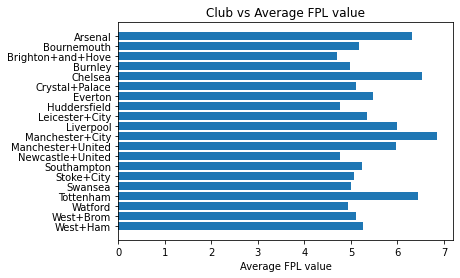

In [61]:
club_averages = {}
for club in data['club'].unique():
    club_players = data.loc[data['club']==club]
    average = sum(
        club_players['fpl_value']
    )
    club_averages[club] = average / len(club_players)

fig, ax = plt.subplots()
ax.barh(
    *zip(
        *club_averages.items()
    )
)
plt.setp(ax.get_xticklabels(), rotation=0)
plt.gca().invert_yaxis()
plt.xlabel('Average FPL value')
plt.title('Club vs Average FPL value')
plt.show()

As we can see from the graph above, the average value for Arsenal, Chelsea, Liverpool, Man City, Man United and Tottenham are the highest. In recent Premier League seasons, these clubs have been known as the "top six" and so, I'll be checking if they are the clubs referred to in the `big_club` variable. If so, we can just use that as a feature as there isn't much as much of a difference between the other subset of clubs.

As we can see below, that is indeed the case.

In [62]:
print(
    set(
        [club for club in data[data['big_club']==1]['club']]
    )
)

{'Tottenham', 'Manchester+City', 'Manchester+United', 'Arsenal', 'Chelsea', 'Liverpool'}


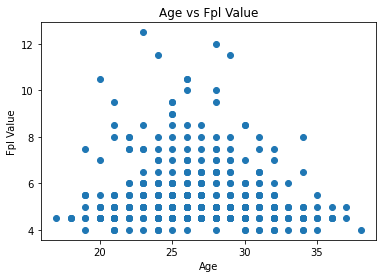

In [63]:
plot_scatter(data, 'age', 'fpl_value')

`age` isn't so clear, but we can see that players below 20 and players above 34 generally have a tighter range of values.

Below, we'll do the same thing as we did earlier - finding the average FPL value for each position in the dataset.

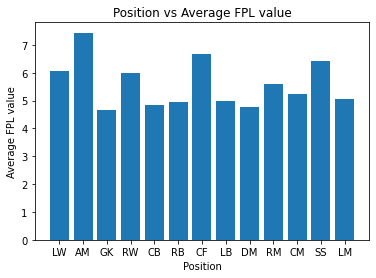

In [64]:
position_averages = {}
for pos in data['position'].unique():
    position = data.loc[data['position']==pos]
    average = sum(
        position['fpl_value']
    )
    position_averages[pos] = average / len(position)

plt.bar(
    position_averages.keys(), list(position_averages.values())
)
plt.title('Position vs Average FPL value')
plt.xlabel('Position')
plt.ylabel('Average FPL value')
plt.show()

In terms of `fpl_value`, we can see that the average values for AM, CF and SS are slightly higher than the rest. This could indeed be useful as a feature - indeed, we'll use `position_cat` as the highest values here are attackers, which are represented as a 1.

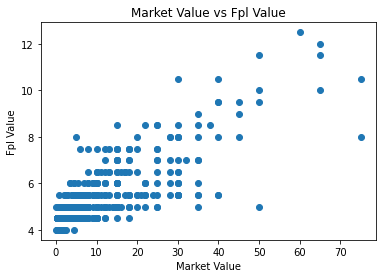

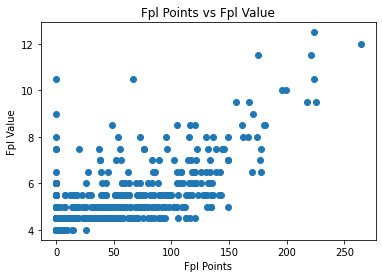

In [65]:
plot_scatter(data, 'market_value', 'fpl_value')
plot_scatter(data, 'fpl_points', 'fpl_value')

There is a more clear correlation with both `market_value` and `fpl_points` although in the case of the latter, we can see a few more outliers on 0 points. I would think the reason why some players who achieved 0 points last season is that they are new to FPL and thus priced according to other statistics (such as performance in other leagues).

Nonetheless, they are both good features to use.

Next, we'll look at the FPL values compared to the new signings in the league.

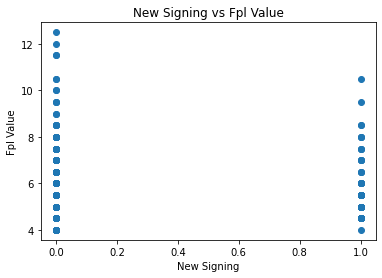

In [66]:
plot_scatter(data, 'new_signing', 'fpl_value')

There isn't a clear distinction between new signings and FPL value, so we won't use this as a feature.

### Creating validation dataset

Now, we'll set `X` to be a subset of the data we created earlier, containing only the features we want to train our algorithm with. `y` will be the column we are trying to predict, so in this case, `fpl_value`. In the previous section, we identified features to use based on strong correlations to the prediction target.

In [67]:
features = ['big_club', 'age', 'position_cat', 'market_value', 'fpl_points']
X = data[features]
y = data['fpl_value']

We'll use the scikit-learn library's function `train_test_split` to split the data into 2 sets. 80% of the data will be used to fit the model and 20% used to validate that our model actually works on *unseen* data.

In [68]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)